In [234]:
import numpy as np
from scipy.signal import butter, filtfilt
from scipy.linalg import expm
from scipy import signal, linalg
import matplotlib.pyplot as plt
import control

In [243]:
def gen_ss(thetaVec):
    m = thetaVec[0]
    k = thetaVec[1]
    c = thetaVec[2]

    ndof = 1

    Ac = np.array([[0, 1],
                   [-k/m, -c/m]])

    Bc = np.array([[0],
                   [1 / m]])

    #it works, because C matrix will come from the last 'few' (1 in case od 1 dof) rows of Ac
    #Similarly D from Bc
    getidx = np.arange(ndof, 2 * ndof)
    C = Ac[getidx, :]

    D = Bc[getidx, :]

    return Ac, Bc, C, D


In [246]:


ndof = 1
dt = 0.01  # sampling period
fs = 1 / dt
T = 10  # final time
t = np.arange(0, T + dt, dt)  # time samples

# force gen.
np.random.seed(19)
utmp = 10 * np.random.randn(len(t))
b, a = butter(5, 5 / (fs / 2), 'low')
u = filtfilt(b, a, utmp)
u = u.reshape(1001,1)
true_m = 1
true_k = 100
kappa = np.log(true_k)
true_c = 0.4
#zeta = true_c / (2 * true_m * np.sqrt(true_k / true_m))
true_theta = np.array([true_m, np.exp(kappa), true_c])
Ac, Bc, C, D = gen_ss(true_theta)

# Convert continuous to discrete
Cfull = np.vstack((np.eye(2 * ndof), C))
Dfull = np.array([[0], [0], [1 / true_m]])
sysc = signal.StateSpace(Ac, Bc, Cfull, Dfull)
sysd = sysc.to_discrete(dt)
Ad = sysd.A
Bd = sysd.B

#Ad_analytical = expm(Ac*dt) (Checks out)
#Bd_analyt = np.linalg.solve(Ac, (Ad - np.eye(2 * ndof)) @ Bc)



In [247]:
#True state:
z0 = np.array([0, 0])
tout, output, _ = signal.lsim2(sysc, u, t, X0=z0)


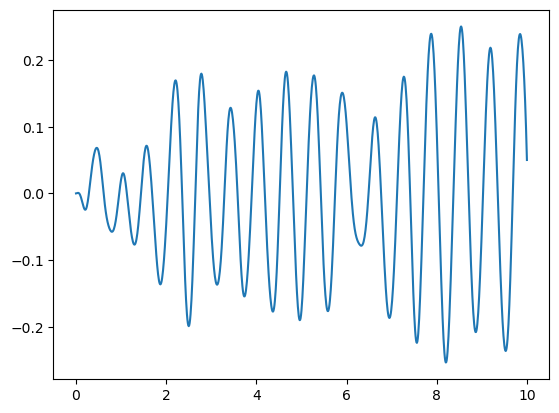

In [248]:
disp = output[:, 0]
plt.plot(t, disp)

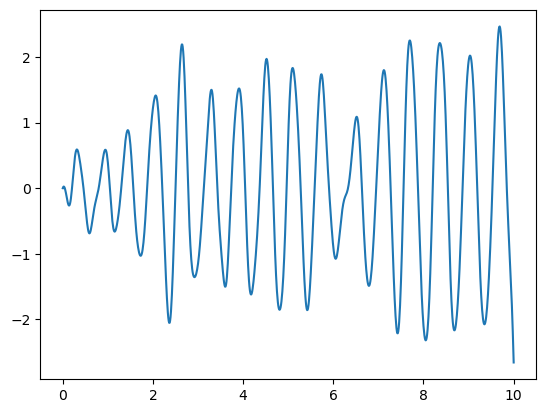

In [249]:
vel = output[:, 1]
plt.plot(t, vel)

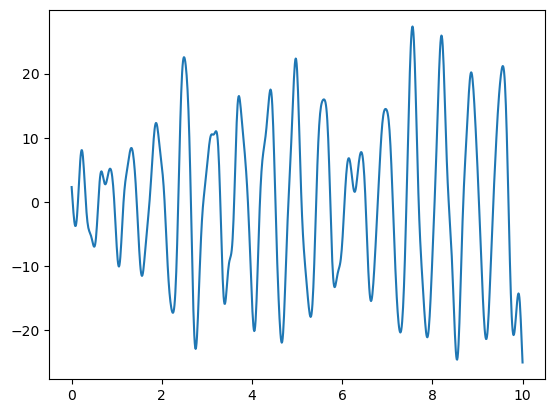

In [250]:
acc = output[:, 2]
plt.plot(t, acc)

In [251]:
#Add Noise
noise_percentage = 10;
noise_std = noise_percentage/100*(np.sqrt(np.mean(acc**2)));
noise = noise_std*np.random.randn(np.size(acc));
y = acc + noise;
y = y.reshape(1001,1)

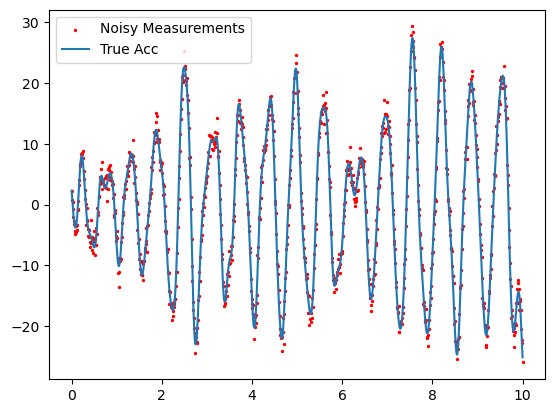

In [252]:
plt.scatter(t,y, label='Noisy Measurements', c='r', s = 2)
plt.plot(t, acc, label = 'True Acc')
plt.legend()

In [253]:
Q = np.diag([0.001, 0.01])
R = 10

Working KF Normal:

In [185]:
#H is C
def kalman_filter(m_0, P_0, A,B,H, D, Q, R,u, observations):
    M = m_0.shape[-1]
    steps, N = observations.shape
    
    kf_m = np.empty((steps, M))
    kf_P = np.empty((steps, M, M))
    
    m = m_0
    P = P_0
    u = u.reshape(1001,1)
    for i in range(steps):
        y = observations[i]
        m = A @ m + B @ u[i]
        P = A @ P @ A.T + Q
        
        S = H @ P @ H.T + R
        # More efficient and stable way of computing K = P @ H.T @ linalg.inv(S)
        # This also leverages the fact that S is known to be a positive definite matrix (assume_a="pos")
        K = linalg.solve(S.T, H @ P, assume_a="pos").T 
        
        m = m + K @ (y - (H @ m + D @ u[i]))
        P = P - K @ S @ K.T
        
        kf_m[i] = m
        kf_P[i] = P
    return kf_m, kf_P

Trying parameter Estimation

In [286]:
#H is C
def kalman_filter(m_0, P_0,Q, R,u, observations, k_curr):
    M = m_0.shape[-1]
    steps, N = observations.shape
    
    kf_m = np.empty((steps, M))
    kf_P = np.empty((steps, M, M))
    
    m = m_0
    P = P_0
    
    #mean and sd on k(theta)
    
    k_sd = 0.1
    #energy{0} = -log(p(theta)); theta= kappa; kappa = log(k) 
    energy = 0.5*np.log(2*np.pi) + 0.5*np.log(k_sd) # +..?
    
    kappa = k_curr + k_sd * np.random.randn(1)
    k = np.exp(kappa) 
    A, B, H, D = get_discrete_mat(1,k,0.4) 
    for i in range(steps):
        y = observations[i]
        m = A @ m + B @ u[i]
        P = A @ P @ A.T + Q
        
        S = H @ P @ H.T + R
        
        # More efficient and stable way of computing K = P @ H.T @ linalg.inv(S)
        # This also leverages the fact that S is known to be a positive definite matrix (assume_a="pos")
        #K = P @ H.T @ linalg.inv(S)
        K = linalg.solve(S.T, H @ P, assume_a="pos").T 
        v = y - (H @ m + D @ u[i])
        m = m + K @ (v)
        P = P - K @ S @ K.T
        
        kf_m[i] = m
        kf_P[i] = P
        
        energy =  energy - 0.5*np.log(np.sum(np.linalg.eig(2*np.pi*S))[0]) + 0.5*v.T @ linalg.inv(S) @ v
    return energy #kf_m, kf_P

In [335]:
def KF(m_0, P_0,Q, R,u, y, k_mean, k_sd, k_curr):
    
    k = np.exp(k_curr)
    A, B, H, D = get_discrete_mat(1,k,0.4)
    steps, N = y.shape

    m = m_0
    P = P_0
    #e = prior on kappa(N(k_mean, k_sd))
    e = 0.5*np.log(2*np.pi) + 0.5*np.log(k_sd) + 0.5*(k_mean-k_curr)**2/(k_sd**2)
    for i in range(100):    
        m = A @ m + B @ u[i]
        P = A @ P @ A.T + Q
        S = H @ P @ H.T + R
        K = linalg.solve(S.T, H @ P, assume_a="pos").T
        v = y[i] - (H @ m + D @ u[i])
        m = m + K @ (v)
        P = P - K @ S @ K.T
        e = e + 0.5*np.log(np.sum(np.linalg.eig(2*np.pi*S)[0])) + 0.5*v.T @ linalg.inv(S) @ v
    return e

In [334]:
k_sd = 0.3
k_mean = 3.5
KF(m_0, P_0,Q, R,u, y, k_mean, k_sd, k_curr)

269.27647728377485

In [309]:
np.linalg.eig(2*np.pi*S)[0]

array([1930.05626294])

In [287]:
k_curr = np.log(100)
kalman_filter(m_0, P_0,Q, R,u, y, k_curr)


C:\Users\SOBAN\AppData\Local\Temp\ipykernel_17196\347826333.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ac = np.array([[0, 1],


ValueError: object arrays are not supported

In [217]:
A = np.array([[2, 0],[0, 2]])
eig_A = np.linalg.eig(A)
np.log(np.sum(eig_A[0]))


1.3862943611198906

In [281]:
a,b,c,d = get_discrete_mat(1, np.exp(2),4.4)
d.shape

(1, 1)

Note: Sir says dont do log(det). Instead use eigen values. 
Since, \
det(A) = prod(eig(A)) \
=> log(det(A)) = sum(log(eig(A)))

In [285]:
def get_discrete_mat(m,k,c):
    true_theta = np.array([m, k, c], dtype=object)
    Ac, Bc, C, D = gen_ss(true_theta)
    Cfull = np.vstack((np.eye(2 * ndof), C))
    Dfull = np.array([[0], [0], [1 / true_m]])
    sysc = signal.StateSpace(Ac, Bc, Cfull, Dfull)
    sysd = sysc.to_discrete(dt)
    Ad = sysd.A
    Bd = sysd.B
    
    return Ad, Bd, C, D

In [336]:
def mcmc(k_0, proposal_noise_0, target_acceptance, n_mcmc, m_0, P_0, Q, dt, R, y, n_particles, random_state,k_mean, k_sd,  do_ram=True, do_ram_from=10):
    
    samples = np.empty(n_mcmc)
    i = 0

    k = k_0
    energy = KF(m_0, P_0,Q, R,u, y, k_mean, k_sd, k)
    proposal_noise = proposal_noise_0
    accepted = 0
        
    pbar = tqdm.trange(n_mcmc)
    pbar.set_description(f'MCMC(accepted=0, current(k)={k})')
    for i in pbar:
        new_k = k + proposal_noise * random_state.randn()
        e = KF(m_0, P_0,Q, R,u, y, k_mean, k_sd, new_k)
        acceptance_proba = min(1, np.exp(energy - e))
        u = random_state.rand()
        if u <= acceptance_proba:
            samples[i] = new_k
            k = new_k
            energy = e
            accepted += 1
            pbar.set_description(f'MCMC(accepted={accepted}, current(k)={k}, proposal_noise={proposal_noise}, energy={energy})')
        else:
            samples[i] = k
            
        if do_ram and (i > do_ram_from):
            nu = 1 / (i**0.9)
            proposal_noise *= np.sqrt(1 + nu * (acceptance_proba - target_acceptance))

    return samples, accepted

In [186]:
m_0 = z0
P_0 = np.diag([0.1, 0.1])

In [187]:
kf_m, kf_P = kalman_filter(m_0, P_0, Ad,Bd, C, D, Q, R,u, y)

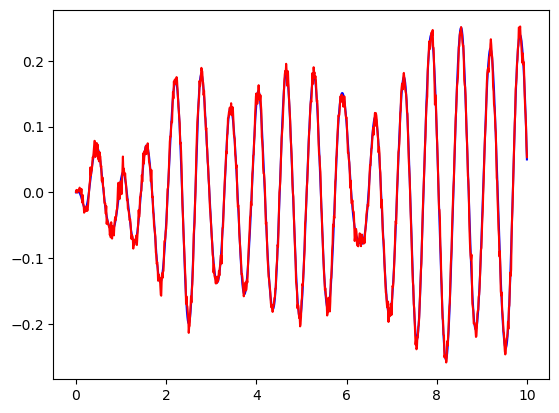

In [121]:
plt.plot(t, disp, c= 'blue')
plt.plot(t, kf_m[:,0], c= 'red')

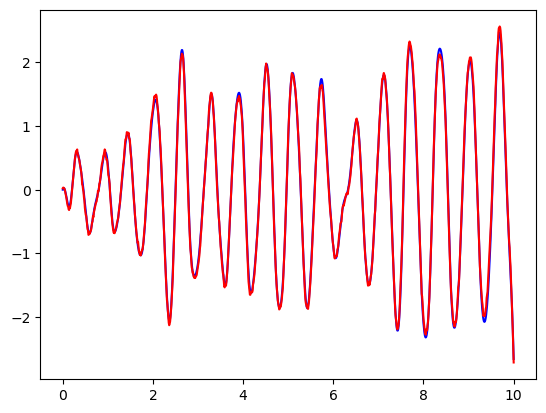

In [122]:
plt.plot(t, vel, c= 'blue')
plt.plot(t, kf_m[:,1], c= 'red')

In [138]:
acc_pred = (C @ kf_m.T + D @ u.T).T
acc_pred.shape

(1001, 1)

In [139]:
y.shape

(1001, 1)

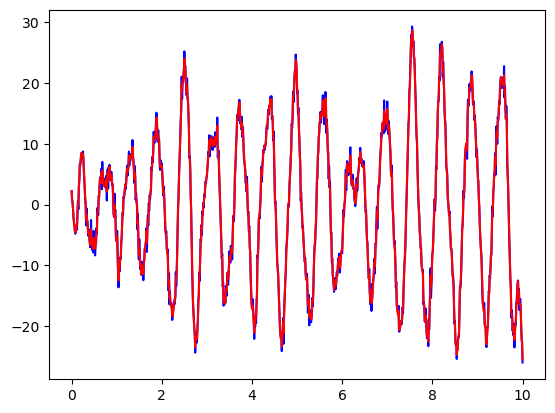

In [140]:
plt.plot(t, y, c= 'blue')
plt.plot(t, acc_pred, c= 'red')

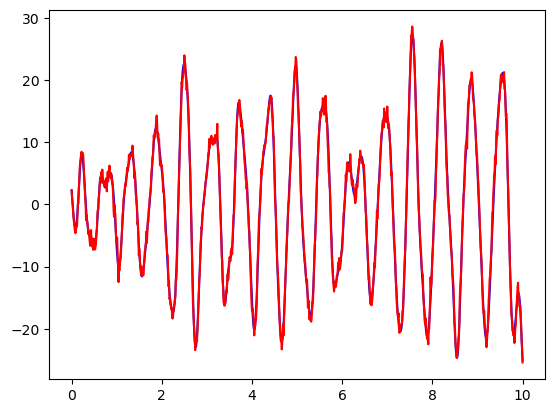

In [141]:
plt.plot(t, acc, c= 'blue')
plt.plot(t, acc_pred, c= 'red')

Say we our initial state estimation was a bit off:

In [148]:
m_0 = np.array([0.4, 0.1]) #intsead of [0,0]
P_0 = np.diag([0.1, 0.1])

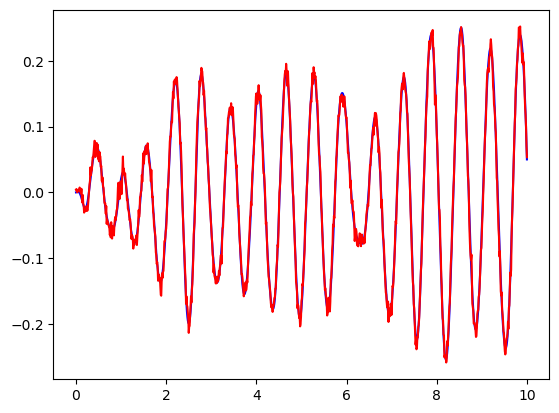

In [154]:
kf_m, kf_P = kalman_filter(m_0, P_0, Ad,Bd, C, D, Q, R,u, y)

plt.plot(t, disp, c= 'blue')
plt.plot(t, kf_m[:,0], c= 'red')


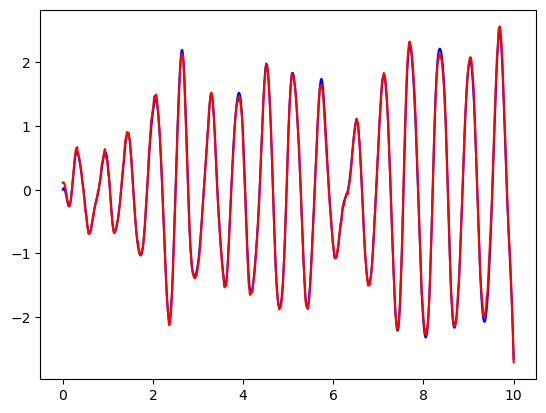

In [150]:

plt.plot(t, vel, c= 'blue')
plt.plot(t, kf_m[:,1], c= 'red')